# MovieLens Dataset Analysis

### Dataset Basic Features
This dataset ml20m describes 5-star rating activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 20.000.263 ratings across 27.278 movies\*.  This data was created by 138.493 users between January 09, 1995 and March 31, 2015. This dataset was generated on March 31, 2015, and updated on October 17, 2016 to update links.csv and add genome-* files.

\* Actually the movie database is 131.262 large, but some movies have no ratings at all. This affects the sparsity structure of the dataset and makes a restructuring of the datasets necessary. (see spy-plot) 

## Sampling entries and loading the matrix

In [36]:
from matplotlib import pyplot as plt
import numpy as np
import csv
import time

In [37]:
from numpy import genfromtxt
data = genfromtxt('/Volumes/data/movielens20/ratings-sample-4.4M.csv',
                  delimiter=',',
                  dtype=(int),
                  skip_header=1,
                  usecols=(0,1)
                 )
print data

[[    1     2]
 [    1    29]
 [    1    32]
 ..., 
 [30358   788]
 [30358   849]
 [30358   858]]


In [38]:
# movies = data[:,1].max()
# users = data[:,0].max()
users, movies = data.max(axis=0)
print "Number of movies: ", movies
print "Number of users: ", users

Number of movies:  131258
Number of users:  30358


In [39]:
ratings = np.zeros((users, movies), dtype=np.int)
for rating in data:
    ratings[rating[0]-1, rating[1]-1] = 1

In [40]:
rating_counts = ratings.sum(axis=1)
print rating_counts.max()
print rating_counts

7515
[175  61 187 ...,  28  20  38]


## User Rating Histogram
How many ratings do users give? How dense is the graph?

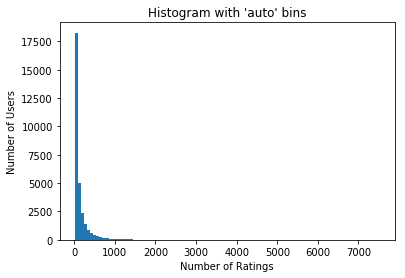

In [42]:
plt.hist(rating_counts, bins=100)
plt.title("Histogram with 'auto' bins")
plt.axis('tight')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

## User Rating Heatmap

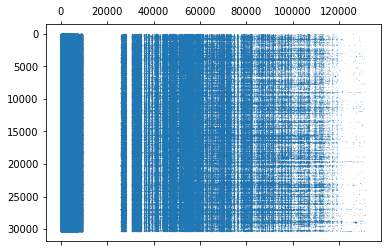

In [134]:
plt.spy(sparse.csr_matrix(ratings), markersize=0.05)
plt.axis('auto')
plt.show()

#### Note: all this is already terribly slow for only 4M sample entries

## Building a dense matrix with numpy

In [10]:
import numpy as np
from numpy import genfromtxt
import os

In [8]:
# for 10k ratings
ratings = get_10k_sample_dense()

In [11]:
np.save('/Volumes/data/ratings-dense-10k.npy', ratings)
print os.path.getsize('/Volumes/data/ratings-dense-10k.npy')/1e6, 'MB'

91.666928 MB


In [12]:
import sys

#### A dense matrix just gets too large too fast.
10k entries are ~90MB on disk and 4.4M ratings result in more than 5GB large files, possibly >30GB (30.358*125.916*8) (estimate because an attempt to write to disk was aborted). The full dataset would theoretically amount to more than 144GB as a dense matrix that is mostly empty.

#### Memory Consumption for double precision dense array

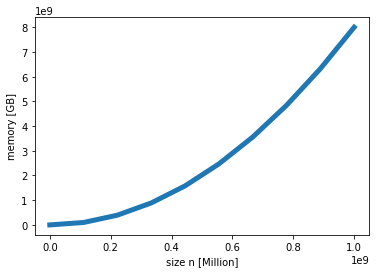

In [20]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0, 1e9, 10)
plt.plot(x, 8.0 * (x**2) / 1e9, lw=5)
plt.xlabel('size n [Million]')    
plt.ylabel('memory [GB]') 
plt.show()

## Building a Sparse Matrix

In [26]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import os

In [53]:
ratings = get_10k_sample_dense()    
mtx_10k = sparse.coo_matrix(ratings)
print mtx_10k.get_shape()
print mtx_10k.nnz, "stored values"

(91, 125916)
6993 stored values


In [39]:
np.save('/Volumes/data/ratings-sparse-10k.npy', mtx_10k)
print os.path.getsize('/Volumes/data/ratings-sparse-10k.npy'), 'Bytes'

112382 Bytes


### Sparse matrix format is a must and much much smaller
10k rating sparse as COO_matrix is 110K on disk! and it's even smaller with .npz compression (~11K)

In [54]:
ratings = get_4M_sample_dense()
mtx_4M = sps.coo_matrix(ratings)
print mtx_4M.get_shape()
print mtx_4M.nnz, " stored elements"

(30358, 131258)
65536  stored elements


In [55]:
np.save('/Volumes/data/ratings-sparse-4M.npy', mtx_4M)
print os.path.getsize("/Volumes/data/ratings-sparse-4M.npy"), 'Bytes'

1049075 Bytes


In [32]:
sparse.save_npz('/Volumes/data/ratings-sparse-4M.npz', mtx)
print os.path.getsize("/Volumes/data/ratings-sparse-4M.npz"), 'Bytes'

## Storage Schemes

Sparse matrices can be used in arithmetic operations: they support addition, subtraction, multiplication, division, and matrix power. There is a variety of different sparse atrix storage schemes in scipy.sparse, each with different advantages and disadvantages:

![Schemes](figures/schemes.jpeg)

### COO Format
Advantages of the COO format:
* facilitates fast conversion among sparse formats
* permits duplicate entries (see example)
* very fast conversion to and from CSR/CSC formats

Disadvantages/does not directly support:
* arithmetic operations
* slicing

Intended Usage:
* COO is a fast format for constructing sparse matrices
* Once a matrix has been constructed, convert to CSR or CSC format for fast arithmetic and matrix vector operations
* By default when converting to CSR or CSC format, duplicate (i,j) entries will be summed together. This facilitates efficient construction of finite element matrices and the like. (see example)

### DOK Format
Advantages of the DOK format:
* efficient for constructing sparse matrices incrementally
* flexible slicing, changing sparsity structure is efficient
* efficient O(1) access to individual elements
* can be efficiently converted to a coo_matrix once constructed

Disadvantages/does not directly support:
* slow arithmetics (for loops with dict.iteritems())

Intended Usage:
* when sparsity pattern is not known apriori or changes

### DOK_matrix building, writing, reading

#### manual

In [62]:
data = np.array([
    [0,1,2,0,5,6],
    [1,2,3,0,5,6],
    [2,3,4,0,5,6]])
csr = sparse.csr_matrix(data)
output_dir = '/Volumes/data/output/'
if os.path.exists(output_dir) is False:
    os.mkdir(output_dir)
file_path = os.path.join(output_dir,'test.npz')
sparse.save_npz(file_path, csr)

In [63]:
loaded = sparse.load_npz(os.path.join(output_dir,'test.npz'))
print type(loaded)
print loaded.todense()

<class 'scipy.sparse.csr.csr_matrix'>
[[0 1 2 0 5 6]
 [1 2 3 0 5 6]
 [2 3 4 0 5 6]]


#### from dense array
doesn't scale, too slow, requires full size dense array

In [175]:
users = 30358 #91 #7
movies = 131258 #125916 #1009

data = genfromtxt(
'/Volumes/data/movielens20/ratings-sample-4.4M.csv',
delimiter=',',
# dtype=(['int8','int8','<f8']),
skip_header=1,
usecols=(0,1,2)
)

dok_matrix = sparse.dok_matrix((users, movies), dtype=np.float)
for rating in data:
    # place the rating at the correct array[user,movie] position
    dok_matrix[rating[0]-1, rating[1]-1] = rating[2]

In [176]:
print dok_matrix.toarray()

[[ 0.   3.5  0.  ...,  0.   0.   0. ]
 [ 0.   0.   4.  ...,  0.   0.   0. ]
 [ 4.   0.   0.  ...,  0.   0.   0. ]
 ..., 
 [ 0.   0.   0.  ...,  0.   0.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   0. ]]


In [181]:
print "dok_matrix[2,588] == 4 >> ", dok_matrix[2,588] == 4.0
print dok_matrix.nnz

dok_matrix[2,588] == 4 >>  True
4442919


In [179]:
path = '/Volumes/data/ratings-sparse-csr-4M.npz'
sparse.save_npz(path, dok_matrix.tocsr())
print os.path.getsize(path), 'Bytes'

12019739 Bytes


In [120]:
dok_matrix[1,2]

3.0

### Incremental loading of predefined X ratings into sparse DOK Matrix

In [33]:
start = time.time()
ratings = '/Volumes/data/movielens20/ratings.csv'
m = load_ratings_to_dok_matrix(20000000, ratings, users=138493, movies=131262)
end = time.time()
print m.nnz
print "Operation took: ", end - start ,"s"
m

20000000
Operation took:  393.383921146 s


<138493x131262 sparse matrix of type '<type 'numpy.float64'>'
	with 20000000 stored elements in Dictionary Of Keys format>

In [102]:
m_multiplied =  m.dot(m.transpose())
print m_multiplied

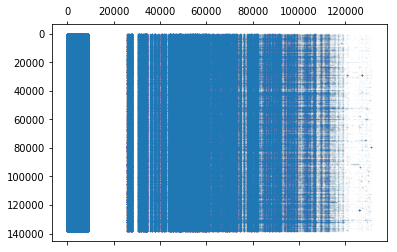

In [29]:
plt.spy(m, markersize=0.005)
plt.axis('tight')
plt.show()

In [121]:
path = '/Volumes/data/ratings-sparse-csr-20M.npz'
sparse.save_npz(path, m.tocsr())
print os.path.getsize(path)/1e6, 'MB'

53.983788 MB


In [ ]:
print os.path.getsize(path)/1e6, 'MB'

In [ ]:
start = time.time()
m = sparse.load_npz(os.path.join(path))
end = time.time()
print "Operation took; ", end - start, "s"
print type(loaded)

In [32]:
start = time.time()
ratings = '/Volumes/data/movielens20/ratings.csv'
m = load_ratings_to_dok_matrix(200000, ratings, users=138493, movies=131262)
end = time.time()
print m.nnz
print "Operation took: ", end - start ,"s"
m

200000
Operation took:  3.20638203621 s


<138493x131262 sparse matrix of type '<type 'numpy.float64'>'
	with 200000 stored elements in Dictionary Of Keys format>

## Helper Methods

In [2]:
def get_10k_sample_dense():
    users = 91
    movies = 125916
    
    data = genfromtxt(
    '/Volumes/data/movielens20/ratings-sample-10k.csv',
    delimiter=',',
    dtype=(['int8','int8','<f8']),
    skip_header=1,
    usecols=(0,1,2)
    )

    ratings = np.zeros((users, movies), dtype=np.float)
    for rating in data:
        # place the rating at the correct array[user,movie] position
        ratings[rating[0]-1, rating[1]-1] = rating[2]

    return ratings

In [4]:
def get_4M_sample_dense():
    users = 30358
    movies = 131258
    
    data = genfromtxt(
    '/Volumes/data/movielens20/ratings-sample-4.4M.csv',
    delimiter=',',
    dtype=(['int8','int8','<f8']),
    skip_header=1,
    usecols=(0,1,2)
    )

    ratings = np.zeros((users, movies), dtype=np.float)
    for rating in data:
        # place the rating at the correct array[user,movie] position
        ratings[rating[0]-1, rating[1]-1] = rating[2]

    return ratings

In [5]:
'''Returns sparse dok_matrix with count elements in it'''
def load_ratings_to_dok_matrix(count, fpath, users=30358, movies=131258, has_header=True):
    counter = 0
    dok_matrix = sparse.dok_matrix((users, movies), dtype=np.float)
    with open(fpath, 'r') as ratings_file:
        if has_header: # skip header line
            ratings_file.next()
        for line in ratings_file:
            if counter < count:
                rating = np.fromstring(line, sep=',')
                dok_matrix[int(rating[0]-1), int(rating[1]-1)] = rating[2]
                counter += 1
            else:
                return dok_matrix

## Conclusion

Using a (compressed) sparse matrix format makes the movielens dataset sufficiently small so that loading data from S3 appears to be not quite so much the limiting factor right now. The dataset is about 50MB in .npz format and can be conveniently split into chunks of sizes 1-5MB and give great flexibility.
Apparently matrix operations are very intensive with regard to main memory. This might actualy the limit to look for. How much matrix operation can a single lambda worker handle(conversion, calculations etc.). That will be a significant factor in how large matrix blocks can and should be.

There is not dedicated block matrix format, the overall matrix will be partitioned into smaller portions as needed and the actual underlying storage scheme will be DOK, CSR/CSC or LIL. 

![Storage Layout](figures/storage-layout.jpeg)

Every worker would load required partitions of the matrix and be able to work on them. This may or may not lead to some overhead as the actually required portion of the overall matrix will be equal to or smaller than the dimensions of x partitions.

## Benchmark

In [317]:
ratings_file = '/Volumes/data/movielens20/ratings.csv'
sizes = np.array([100, 200, 400, 1000]) * 1000
for size in sizes:
    mtx = load_ratings_to_dok_matrix(size, ratings_file)
    output_file = os.path.join('/Volumes/data/output/', str(size), 'block0')
    sparse.save_npz('/Volumes/data/output/ratings-block.npz', mtx)
    print os.path.getsize("/Volumes/data/ratings-sparse-4M.npz"), 'Bytes'
    

array([ 100000,  200000,  400000, 1000000])

# Sample Code

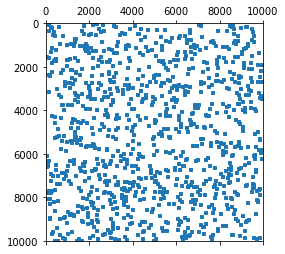

In [96]:
A = sparse.rand(10000,10000, density=0.00001)
M = sparse.csr_matrix(A)
plt.spy(M, markersize=3)
plt.show()

## Constructing a matrix with pandas
from raw data using pandas

In [52]:
import os
import pandas as pd

In [53]:
data_path = "/Volumes/data/movielens20"
file_path = "ratings-sample-10k.csv"
path = os.path.join(data_path, file_path)
df = pd.read_csv(path)
df.columns = ['User', 'Item', 'Rating', 'timestamp']

In [55]:
df.pivot(index='User', columns='Item', values='Rating')

Item,1,2,3,4,5,6,7,8,9,10,...,111921,112138,112290,112556,112852,116797,117511,117590,118696,125916
User,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df.values

array([[  1.00000000e+00,   2.00000000e+00,   3.50000000e+00,
          1.11248603e+09],
       [  1.00000000e+00,   2.90000000e+01,   3.50000000e+00,
          1.11248468e+09],
       [  1.00000000e+00,   3.20000000e+01,   3.50000000e+00,
          1.11248482e+09],
       ..., 
       [  9.10000000e+01,   2.79700000e+03,   3.50000000e+00,
          1.11206122e+09],
       [  9.10000000e+01,   2.85700000e+03,   4.00000000e+00,
          1.11196678e+09],
       [  9.10000000e+01,   2.85800000e+03,   4.50000000e+00,
          1.11155748e+09]])

## Histogram Demo Code

In [346]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

np.random.seed(0)

# example data
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = mu + sigma * np.random.randn(437)

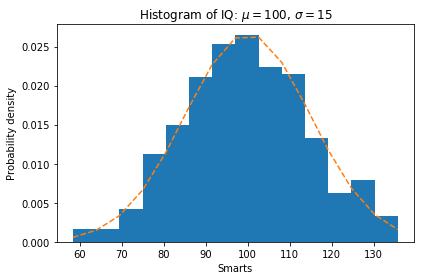

In [364]:
num_bins = 14

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, normed=1)

# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()